# What Geospatial Analysis tells us about Meatpacking & COVID-19
https://carto.com/blog/open-source-spatial-libraries-covid19-analysis/

In [412]:
import cartoframes
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import datashader as ds

from datashader.transfer_functions import stack
from datashader.transfer_functions import shade
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background

from datashader.colors import viridis
from xrspatial.classify import binary
from xrspatial import proximity

from spatialpandas import GeoDataFrame 
import xarray as xr

## Cartoframes Authentication

In [ ]:
creds=cartoframes.auth.Credentials(username='<CARTO_USER>', api_key='<CARTO_KEY>',
                                   base_url= '<CARTO_BASE>', session=None, allow_non_secure=False)

In [414]:
from cartoframes.auth import set_default_credentials

set_default_credentials(creds)

/home/ubuntu/miniconda/envs/tileshader/lib/python3.7/site-packages/cartoframes/auth/defaults.py:96: ResourceWarning: unclosed <socket.socket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.31.36.171', 57316), raddr=('104.154.25.41', 443)>
  _default_credentials = _credentials


## Define Study Area

In [415]:
from datashader.colors import inferno
x_range = (-124.848974, -66.885444)
y_range = (24.396308, 49.384358)

W = 1600
H = 800

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=x_range, y_range=y_range)


## Counties

## Load Counties Data

In [416]:
from cartoframes import read_carto

covid_gdf = read_carto('jhopkins_counties')
covid_gdf['confirmed_ra'] = covid_gdf['confirmedb'] / covid_gdf['agetotal']

meat_df_gdf = read_carto('meat_df_gdf')
meat_df_gdf['x'] = meat_df_gdf['the_geom'].x
meat_df_gdf['y'] = meat_df_gdf['the_geom'].y
meat_df_gdf = meat_df_gdf[['x','y']]

covid_gdf, meat_df_gdf

/home/ubuntu/miniconda/envs/tileshader/lib/python3.7/site-packages/cartoframes/utils/metrics.py:100: ResourceWarning: unclosed <socket.socket fd=48, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.31.36.171', 58000), raddr=('104.154.25.41', 443)>
  result = func(*args, **kwargs)
/home/ubuntu/miniconda/envs/tileshader/lib/python3.7/site-packages/cartoframes/utils/metrics.py:100: ResourceWarning: unclosed <socket.socket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.31.36.171', 58006), raddr=('104.154.25.41', 443)>
  result = func(*args, **kwargs)


(      cartodb_id                                           the_geom  objectid  \
 0              1  POLYGON ((-86.413 32.707, -86.412 32.527, -86....         1   
 1              2  MULTIPOLYGON (((-87.789 31.299, -87.788 31.297...         2   
 2           2980  MULTIPOLYGON (((-122.420 47.321, -122.335 47.2...      2980   
 3              3  POLYGON ((-85.256 32.138, -85.256 32.136, -85....         3   
 4            620  POLYGON ((-88.654 39.216, -88.570 39.215, -88....       620   
 ...          ...                                                ...       ...   
 3253        3136  POLYGON ((-107.085 44.997, -106.264 44.994, -1...      3136   
 3254        3144                           GEOMETRYCOLLECTION EMPTY      3144   
 3255        3137  POLYGON ((-109.755 43.463, -109.754 43.366, -1...      3137   
 3256        3138  POLYGON ((-109.751 42.266, -109.497 42.263, -1...      3138   
 3257        3139  POLYGON ((-110.668 44.666, -110.668 44.583, -1...      3139   
 
       countyn

In [411]:
from cartoframes.viz import Map, Layer, basemaps

meat_df_gdf2 = read_carto('meat_df_gdf')

meat_layer = Layer(meat_df_gdf2, style=dict(color="red", width=10, strokeWidth=2, strokeColor="#C7C7C7"))

Map([meat_layer], basemap=basemaps.voyager)

/home/ubuntu/miniconda/envs/tileshader/lib/python3.7/site-packages/cartoframes/utils/metrics.py:100: ResourceWarning: unclosed <socket.socket fd=48, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.31.36.171', 57500), raddr=('104.154.25.41', 443)>
  result = func(*args, **kwargs)
/home/ubuntu/miniconda/envs/tileshader/lib/python3.7/site-packages/cartoframes/utils/utils.py:538: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  parameter_args = inspect.getargspec(decorated_function).args


In [386]:
meat_df_gdf2

,cartodb_id,the_geom,company,est__number,street_address,city,state,zipcode,boneless_beef,finished_product,supplements,contact_name_and_phone_number,address,gc_status_rel,carto_geocode_hash
0,1,POINT (-117.70110 34.00500),American Beef Packers,M34741,13677 Yorba Avenue,Chino,CA,91710,x,x,704,Kari Godbey (626) 922-4585,13677 Yorba Avenue CA 91710,0.91,5ecde6f0f009bd7847d14e8ac9665075
1,2,POINT (120.18503 22.99162),NaN,NaN,NaN,NaN,NaN,NaN,Supplies:,NaN,NaN,NaN,NaN,0.38,14cc3b30e5052d4f486d07eac20706a0
2,3,POINT (-121.43375 37.76805),American Custom Meats,M44189,4276 N. Tracy Blvd.,Tracy,CA,95304,NaN,x,210,Charles Brust (209) 839-8800,4276 N. Tracy Blvd. CA 95304,0.95,ae436dfbf1690a292d9674eb8172cfbb
3,4,POINT (-87.97995 44.51055),American Foods Group,M410,544 Acme Street P.O. Box 8547,Green Bay,WI,54302,x,NaN,"404, 704",Ashley Lembke (651) 256-6109,544 Acme Street P.O. Box 8547 WI 54302,0.91,8b5b18cda5679d56c355611e6382e702
4,5,POINT (-88.00363 44.51681),American Foods Group,M18076,800 University Avenue,Green Bay,WI,54302,NaN,x,211,Ashley Lembke (651) 256-6109,800 University Avenue WI 54302,0.91,a963cf3279882ad6ae6c14653c94cd84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,133,POINT (-88.27083 42.52954),Kiva Sun Foods (Double J Meat Packing),M322,726 West Main Street,Pierce,CO,80650,x,NaN,Mark Freeland (505) 228-9379,NaN,726 West Main Street CO 80650,0.92,a4eec52cb24892754bbd7fbcc714351a
133,134,POINT (-104.97577 39.78752),Kiva Sun Foods (Frontiere Natural Meats),M17086,810 East 50th Avenue,Denver,CO,80216,NaN,x,Mark Freeland (505) 228-9379,NaN,810 East 50th Avenue CO 80216,0.95,dbd492c359e139bc73359ac9522751dc
134,135,POINT (-97.34155 37.71006),Native American Enterprises,M5541-A,230 North West Street,Wichita,KS,67203,NaN,x,William McGreevy (316) 946-5522,NaN,230 North West Street KS 67203,0.94,bdd05874f6999946990dbc7da09cdabe
135,136,POINT (-99.11711 47.64813),North American Bison Cooperative,M18859,1658 Highway 281,New Rockford,ND,58356,x,NaN,Mike Jacobson (701) 356-7720,NaN,1658 Highway 281 ND 58356,0.89,245d111334700df77c8eb31d1173e0f4


In [417]:
covid_gdf.corr()['age_65_69'].sort_values(ascending=False).to_dict()

{'age_65_69': 1.0,
 'age_65_74': 0.9988285194291625,
 'agedpop': 0.9977947472326896,
 'age_70_74': 0.9975634452942873,
 'age_75_79': 0.9938537684643901,
 'age_80_84': 0.9917869148681615,
 'age_over75': 0.9912531286243328,
 'age_35_64': 0.9898193428851763,
 'agetotal': 0.9891659894500134,
 'not_hisp': 0.9891659894500134,
 'totalpop': 0.9891659894500134,
 'pop_estima': 0.9890180738581605,
 'age_85': 0.9837825932736923,
 'age_15_24': 0.9777318862406833,
 'wh_alone': 0.9768219734724733,
 'nonhisp': 0.9749542263705112,
 'age_less15': 0.9745365575157878,
 'age_25_34': 0.9731712755089599,
 'unemployed': 0.970458714361528,
 'povall_201': 0.9458741414393462,
 'beds_staff': 0.9397583792641692,
 'nonhispwhp': 0.9382536546804903,
 'beds_licen': 0.9279216592196537,
 'ventilator': 0.9149086274899869,
 'two_more': 0.9056282347953886,
 'beds_icu': 0.8997523524619752,
 'twomorpop': 0.87455337749074,
 'hisppop': 0.8551985812983902,
 'as_alone': 0.8141421592795216,
 'asianpop': 0.8135101701660408,
 'so_a

## Meatpacking plants in US

## Geocode with Carto

## Load Covid data

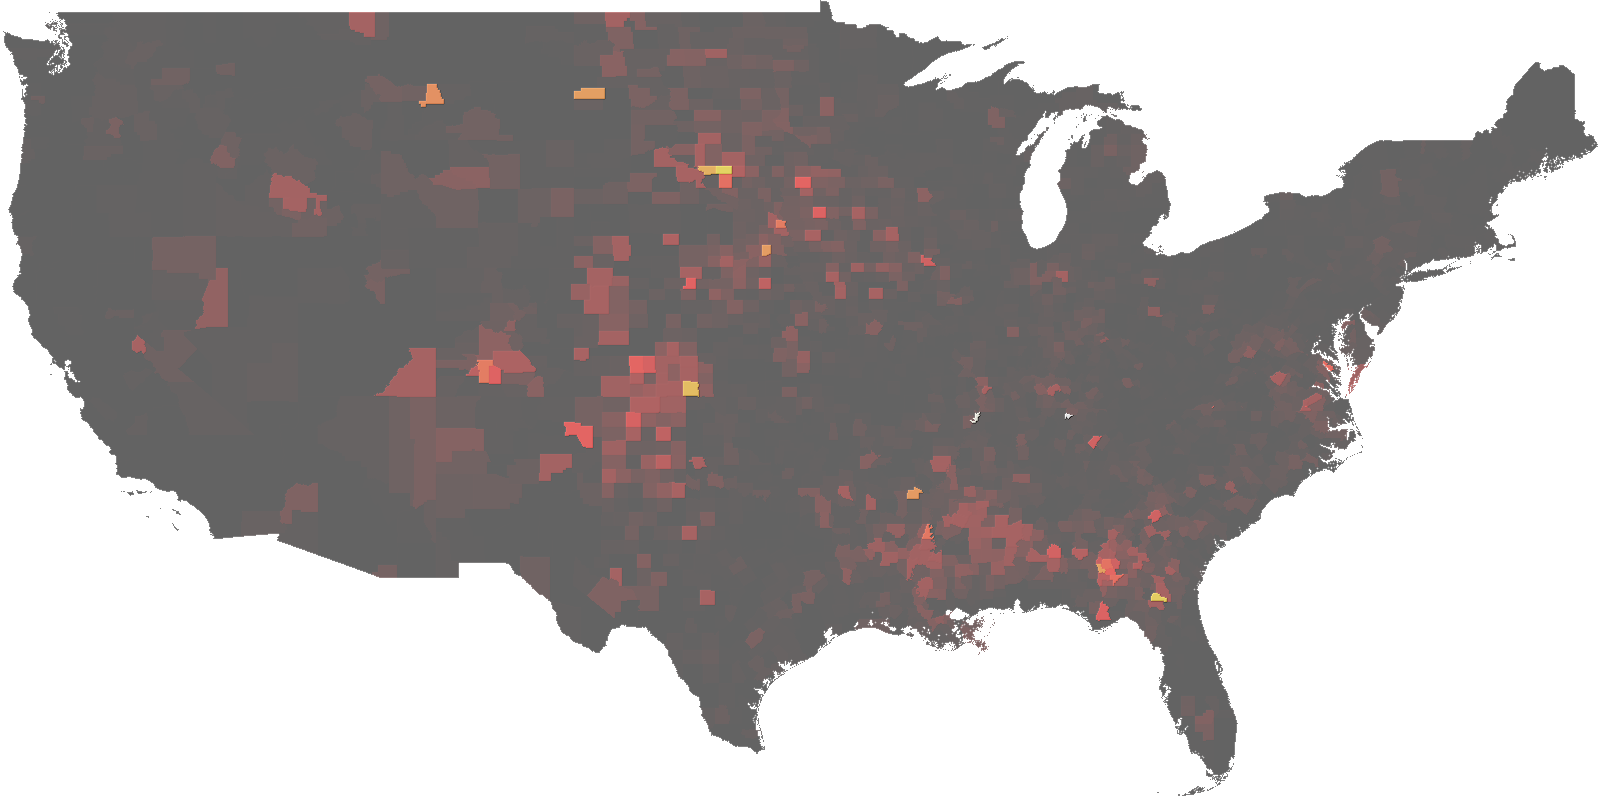

In [432]:
from shapely.geometry import shape, MultiPolygon, Polygon
from datashader.colors import Hot, Greys9
from xrspatial import hillshade
from xrspatial import equal_interval, quantile, natural_breaks

covid_gdf = covid_gdf[covid_gdf.apply(lambda d: isinstance(d['the_geom'], (MultiPolygon, Polygon)), axis=1)]
covid_spatial_pandas = GeoDataFrame(covid_gdf, geometry='the_geom')
counties_raster = cvs.polygons(covid_spatial_pandas, geometry='the_geom', agg=ds.mean('confirmed_ra'))
counties_mask = cvs.polygons(covid_spatial_pandas, geometry='the_geom')

layers = []
layers.append(shade(hillshade(counties_raster), cmap=Greys9, alpha=225, how='log'))
layers.append(shade(counties_raster, cmap=Hot, alpha=128, how='log'))

counties_image = stack(*layers)
set_background(counties_image, 'white')

In [364]:
df3 = counties_raster.to_pandas().stack().reset_index().set_index(['y', 'x'])
df3.columns = ['covid_rate']
df3

covid_rate
y         x                     
24.536866 -82.155211    0.001991
          -82.118984    0.001991
          -82.010303    0.001991
          -81.974075    0.001991
          -81.937848    0.001991
...                          ...
49.337505 -95.015870    0.000000
          -94.979642    0.000000
          -94.943415    0.000000
          -94.907188    0.000000
49.368740 -95.124551    0.000000

[724364 rows x 1 columns]

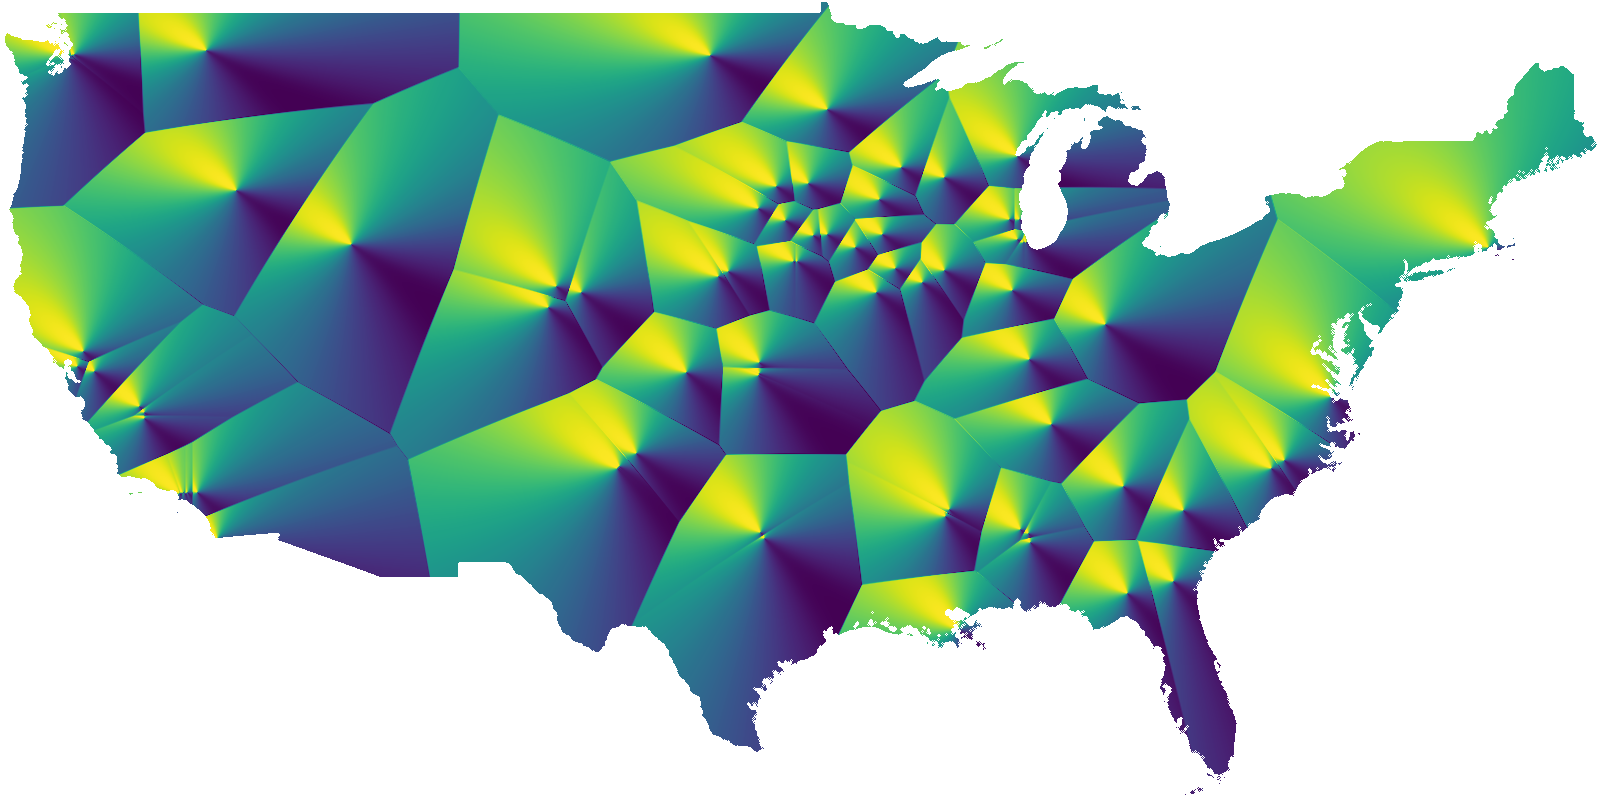

In [349]:
meat_points = cvs.points(meat_df_gdf, x='x', y='y')
meat_raster = proximity(meat_points, distance_metric='GREAT_CIRCLE')
meat_raster = meat_raster.where(counties_mask)

meat_hillshade = hillshade(meat_raster)
meat_image = shade(meat_hillshade, cmap=reversed(viridis))
set_background(meat_image, 'white')

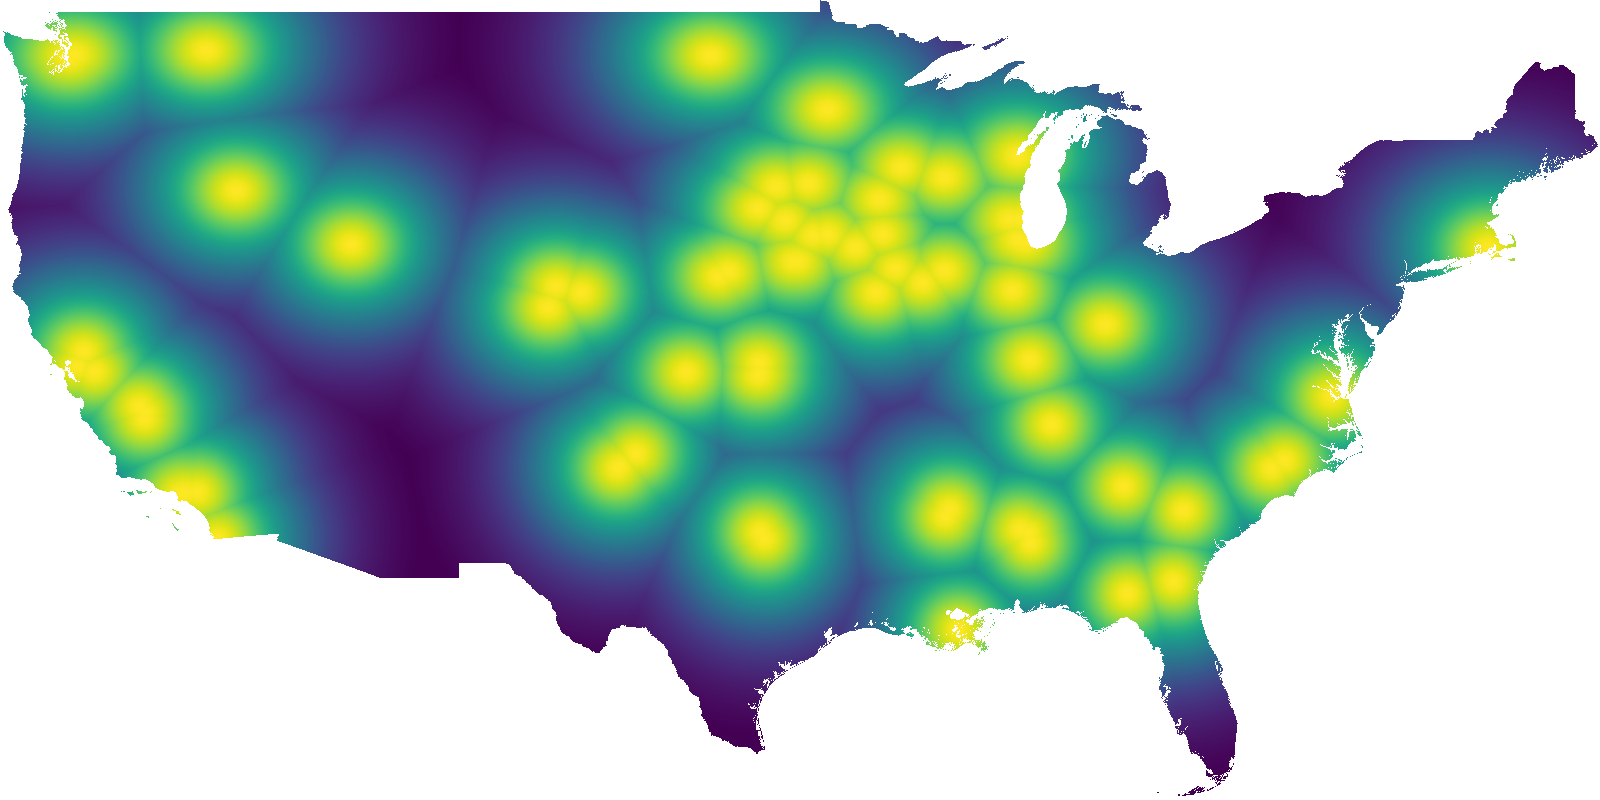

In [350]:

meat_image = shade(meat_raster, cmap=reversed(viridis))
set_background(meat_image, 'white')

In [136]:
from cartoframes.viz import palettes

In [334]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()


counties_values = (counties_raster.to_pandas()
                                  .stack('x')
                                  .reset_index()
                                  .set_index(['y','x']))
counties_values.columns = ['confirmed_ra']
counties_values['confirmed_ra_log'] = counties_values['confirmed_ra'].apply(np.log)
counties_values = counties_values.replace([np.inf, -np.inf], np.nan)
counties_values['confirmed_ra_log'] = min_max_scaler.fit_transform(counties_values[['confirmed_ra_log']].values)
#counties_values['confirmed_ra_log'] = counties_values['confirmed_ra_log'].replace([np.nan], 0)


meat_values = (meat_raster.to_pandas()
                          .stack('x')
                          .reset_index()
                          .set_index(['y','x']))
meat_values.columns = ['distance']
meat_values['distance'] = min_max_scaler.fit_transform(meat_values[['distance']].values)

df = meat_values.merge(counties_values, left_index=True, right_index=True)

df

distance  confirmed_ra  confirmed_ra_log
y         x                                                   
24.536866 -82.155211  0.984815      0.001991          0.352462
          -82.118984  0.985427      0.001991          0.352462
          -82.010303  0.987329      0.001991          0.352462
          -81.974075  0.987984      0.001991          0.352462
          -81.937848  0.988649      0.001991          0.352462
...                        ...           ...               ...
49.337505 -95.015870  0.689380      0.000000               NaN
          -94.979642  0.691578      0.000000               NaN
          -94.943415  0.693775      0.000000               NaN
          -94.907188  0.695969      0.000000               NaN
49.368740 -95.124551  0.684542      0.000000               NaN

[724364 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6f5796c90>,
      dtype=object)

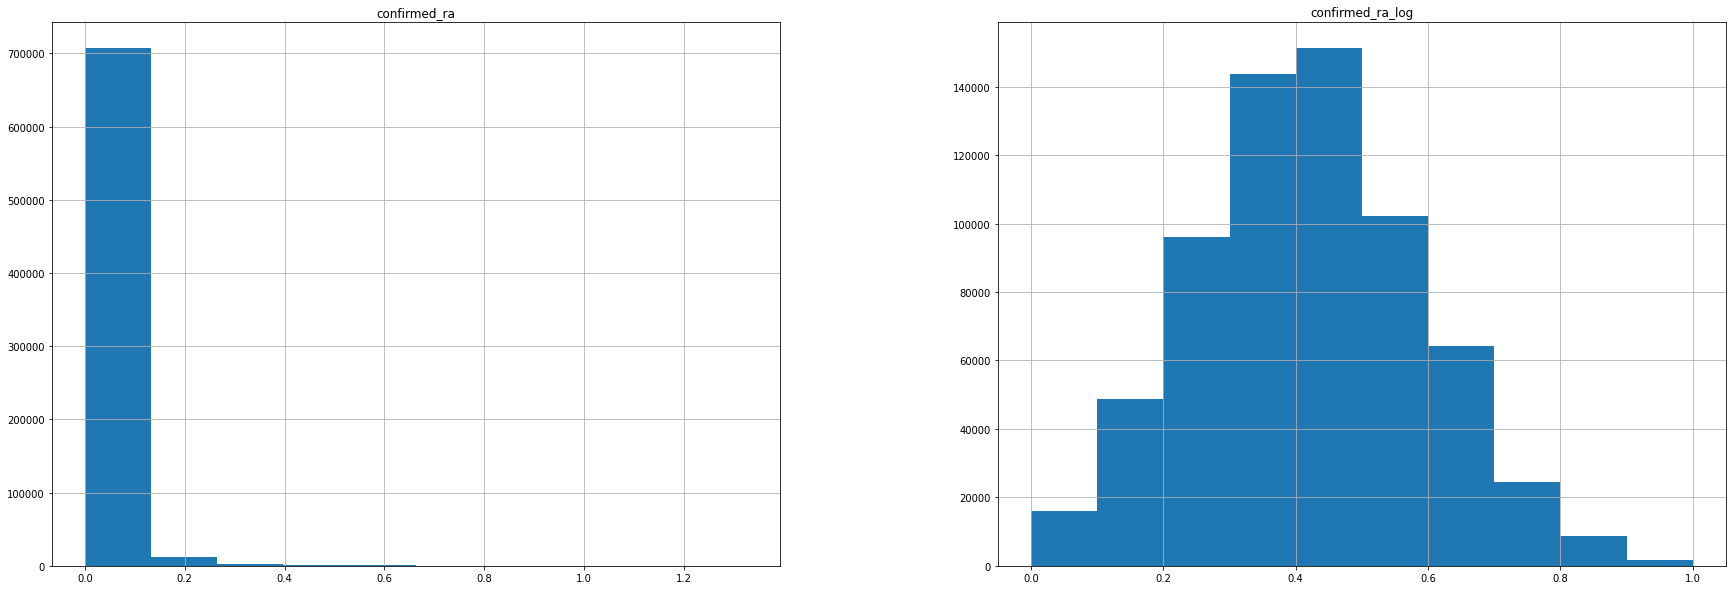

In [431]:
df[['confirmed_ra','confirmed_ra_log']].hist(figsize=(30,10))

In [357]:
df.corr()

,distance,confirmed_ra_log
distance,1.000000,-0.253732
confirmed_ra_log,-0.253732,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6f681c310>,
      dtype=object)

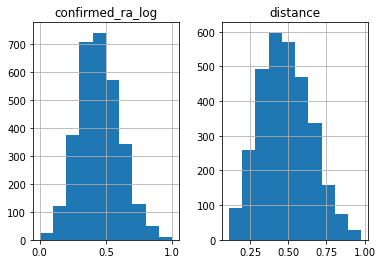

In [354]:
df.groupby('confirmed_ra').agg('mean').hist()